In [1]:
%matplotlib inline
import numpy as np
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import pydicom
import SimpleITK as sitk
import astra
from ipywidgets import interact

In [2]:
def find_paths_with_id(root_directory):
    paths_with_id = []
    
    # Walk through the directory
    for dirpath, dirnames, filenames in os.walk(root_directory):
        # Check each directory and file name for the 'ID' pattern
        for name in dirnames + filenames:
            if 'ID' in name:
                # Construct the full path and add to list
                full_path = os.path.join(dirpath, name)
                paths_with_id.append(full_path)
                
    return paths_with_id
id_paths = find_paths_with_id('*')

In [4]:

from pathlib import Path
import os
import numpy as np
import re
import pydicom
import copy
import json
import matplotlib.pyplot as plt
from gecatsim.pyfiles.GetMu  import GetMu
from gecatsim.pyfiles.CommonTools import source_cfg


class IndexTracker:
    # Tracker for allowing scroll wheel to move through a large number of images
    # The images are assumed to be stored as [image_number, x, y]
    # In the event that the images are stored as [x, y, image number] update [self.ind, :, :] -> [:, :, self.ind]
    def __init__(self, ax, X):
        self.ax = ax
        self.X = X
        self.slices, rows, cols = X.shape
        self.ind = self.slices//2
        self.im = ax.imshow(self.X[self.ind, :, :]) # initialize the image number
        self.update() # draw the default image (typically the central slice)

    def on_scroll(self, event): # when the wheel has scrolled
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices # increment image number by one
        else:
            self.ind = (self.ind - 1) % self.slices # decrement image number by one
        self.update() # update the image

    def update(self): # When updating
        self.im.set_data(self.X[self.ind, :, :]) # select the image
        self.ax.set_ylabel('slice %s' % self.ind) # title the y axis with the image number
        self.im.axes.figure.canvas.draw() # update the figure with the selected image
        

def initialize(phantom):

   
    if not os.path.exists(phantom.dicom_path):
        raise Exception('******** Error! {:s} not found..'.format(phantom.dicom_path))
    allfiles = [f for f in os.listdir(phantom.dicom_path) if os.path.isfile(os.path.join(phantom.dicom_path, f))]
    dcmfiles = [j for j in allfiles if '.dcm' in j]
    if len(dcmfiles) == 0:
        raise Exception('******** Error! No DICOM files exist in {:s}.'.format(phantom.dicom_path))

    # Sort DICOM files: Initial order is alphabetical - switch to numeric.
    dcm_num = []
    for dicom_filename in dcmfiles:
        # dicom number in the file name - alphabetical order - convert to number
        # print(dicom_filename)
        dcm_num.append(int(re.findall(r'\d+', dicom_filename)[0]))
    # print(dcm_num)
    
    # sort the dicom numbers by numeric order
    indices = sorted(range(len(dcm_num)),key=dcm_num.__getitem__)
    # print(indices)
    # find the index associated with the new sorted number to open files in numeric rather than alphabetic order
    dicom_filenames = [dcmfiles[index] for index in indices]
    # print(dicom_filename)
    # If a range of slices was specified, reduce the list of files.
    try:
        # check if ranges for slices are given
        try:
            # If a single range is given use that range of slices
            test = list(range(phantom.slice_range[0], 1 + phantom.slice_range[1]))
        except:
            test = []
            for j in phantom.slice_range:
                # if a series of ranges are given then include the slices in each range
                test += list(range(j[0], 1+j[1]))
        # filter the dicom data on the selected range(s)
        dicom_filenames = [dicom_filenames[i] for i in test]
    except:
        # keep the original if the ranges are inappropriate or if slice_range is not specified.
        dicom_filenames = dicom_filenames

    # Read in one DICOM file to use as a sample.
    dicom_filename = os.path.join(phantom.dicom_path, dcmfiles[0])
    # sample_dicom = []
    sample_dicom = pydicom.dcmread(dicom_filename)

    # Display basic information about the DICOM dataset.
    try:
        PatientAge = sample_dicom.PatientAge
    except:
        PatientAge = 'Unavailable'

    try:
        PatientSex = sample_dicom.PatientSex
    except:
        PatientSex = 'Unavailable'

    try:
        Manufacturer = sample_dicom.Manufacturer
    except:
        Manufacturer = 'Unavailable'

    try:
        ManufacturerModelName = sample_dicom.ManufacturerModelName
    except:
        ManufacturerModelName = 'Unavailable'

    try:
        StudyDate = sample_dicom.StudyDate
    except:
        StudyDate = 'Unavailable'

    try:
        StudyDescription = sample_dicom.StudyDescription
    except:
        StudyDescription = 'Unavailable'

    try:
        KVP = sample_dicom.KVP
    except:
        KVP = 'Unavailable'

    try:
        XRayTubeCurrent = sample_dicom.XRayTubeCurrent
    except:
        XRayTubeCurrent = 'Unavailable'

    try:
        ConvolutionKernel = sample_dicom.ConvolutionKernel
    except:
        ConvolutionKernel = 'Unavailable'

    try:
        ReconstructionDiameter = sample_dicom.ReconstructionDiameter
    except:
        ReconstructionDiameter = 'Unavailable'

    try:
        PixelSpacing = sample_dicom.PixelSpacing[0]
    except:
        PixelSpacing = 'Unavailable'

    try:
        SliceThickness = sample_dicom.SliceThickness
    except:
        SliceThickness = 'Unavailable'

   
    phantom.basename = os.path.basename(phantom.phantom_path)
    phantom.num_materials = len(phantom.materials)
    phantom.num_cols = sample_dicom.Columns
    phantom.num_rows = sample_dicom.Rows
    phantom.num_slices = len(dicom_filenames)
    phantom.pixel_size_x = sample_dicom.PixelSpacing[0]
    phantom.pixel_size_y = sample_dicom.PixelSpacing[1]
    phantom.pixel_size_z = sample_dicom.SliceThickness
    phantom.mu_water = GetMu('water', phantom.mu_energy)
    phantom.mu_water = phantom.mu_water[-1]
    phantom.json_filename = phantom.phantom_path + '/' + phantom.basename + '.json'

    filenames_first_part = phantom.phantom_path + '/' + phantom.basename + '_'
    filenames_last_part = '_' + str(phantom.num_cols) + 'x' + str(phantom.num_rows) + 'x' + str(phantom.num_slices) + '.raw'
    mu_list = []
    volume_fraction_array = {}
    volume_fraction_filenames = []
    for index, material in enumerate(phantom.materials):
        
        # Calculate mu values for each material.
        mu_list.append(GetMu(material, phantom.mu_energy)[0])
        
        # Allocate an array for the volume fraction map of each material.
        volume_fraction_array.update({material: np.zeros((phantom.num_slices, phantom.num_cols, phantom.num_rows), dtype=np.float32)})

        # Assign output filenames for each material.
        volume_fraction_filenames.append(filenames_first_part + material + filenames_last_part)

        # Calculate the thresholds - mu boundaries between materials
        if material == phantom.materials[0]:
            threshold_list = [0]
        else:
            # 55% lower mu material, 45% upper mu material
            threshold_list.append(mu_list[index-1]*0.55 + mu_list[index]*0.45)

    # Allocate an array for the HU data.
    volume_fraction_array.update({'HU data': np.zeros((phantom.num_slices, phantom.num_cols, phantom.num_rows), dtype=np.float32)})

    # Assign an output filename for the HU data.
    volume_fraction_filenames.append(filenames_first_part + 'HU_data' + filenames_last_part)

    # sort the mu_list and keep the index of the new values
    indices = sorted(range(len(mu_list)), key=mu_list.__getitem__)

    # for each index calculate the threshold between the previous and current materials
    # match the order for the mu, materials, and thresholds
    mu_list1 = [mu_list[index] for index in indices]
    material_names1 = [phantom.materials[index] for index in indices]
    for index, material in enumerate(material_names1):
        if material == material_names1[0]:
            threshold_list1 = [0]
        else:
            # 55% lower mu material, 45% upper mu material
            threshold_list1.append(mu_list1[index-1]*0.55 + mu_list1[index]*0.45)

    # Initialize the material dictionary.
    materials_dict = {'material_names': material_names1,
                      'volume_fraction_filenames': volume_fraction_filenames,
                      'mu_values': mu_list1,
                      'threshold_values': threshold_list1}

    # print('*')
    # print('*********************************************')
    # print('* Segmentation parameters:')

    # If thresholds were correctly specified in the config file, over-ride calculated thresholds.
    try: 
        if len(phantom.thresholds) == len(materials_dict['threshold_values']):
            # First convert the specified thresholds to LACs (mu).
            mu_thresholds = [(hu + 1000) * phantom.mu_water / 1000 for hu in phantom.thresholds]
            materials_dict.update({'threshold_values': mu_thresholds})
            # print('* Using thresholds specified in the config file.')
    except:
    #    print('* Using calculated thresholds.')
       phantom.thresholds = materials_dict['threshold_values']

    
    if not os.path.exists(phantom.phantom_path):
        os.makedirs(phantom.phantom_path)
  

    return phantom, dicom_filenames, volume_fraction_array, materials_dict


def compute_volume_fraction_array(phantom, dicom_filenames, materials_dict, volume_fraction_array):

    threshold_list = materials_dict['threshold_values']
    material_names = materials_dict['material_names']
    mu_list = materials_dict['mu_values']

    for dcm_index, dicom_filename in enumerate(dicom_filenames):
        dicom_pathname = os.path.join(phantom.dicom_path, dicom_filename)
        dicom_data = pydicom.dcmread(dicom_pathname)             # Read DICOM file
        hu_array = dicom_data.pixel_array                        # Extract the data - in HU but with a "rescale intercept".
        hu_array = hu_array + int(dicom_data.RescaleIntercept)   # Add the "rescale intercept" to get it into HU.
        volume_fraction_array['HU data'][dcm_index] = hu_array   # Store the HU data in the volume fraction array
        mu_array = (hu_array + 1000) * phantom.mu_water / 1000   # Convert HU to LAC (mu)
        mu_array[mu_array < 0] = 0                               # Remove negative values (non-physical)
        bounds = copy.deepcopy(threshold_list)                   # Prevent the next line from appending to threshold_list
        bounds.append(1.1*mu_array.max())                        # Set the upper bound for the last material to include the highest pixel in the array
        for material_index, material in enumerate(material_names):  # For each material,
            array0 = copy.deepcopy(mu_array)                     # Start with the mu array,
            array0[array0 < bounds[material_index]] = 0          # Zero out pixels below lower threshold
            array0[array0 >= bounds[material_index+1]] = 0       # Zero out pixels above upper threshold
            array0 /= mu_list[material_index]                    # Calculate mu fraction relative to mu for this material.
            volume_fraction_array[material][dcm_index] = array0  # Store the mu fraction in the volume fraction array

    return volume_fraction_array


def write_files(phantom, materials_dict, volume_fraction_array):

    volume_fraction_filenames = materials_dict['volume_fraction_filenames']
    material_names = materials_dict['material_names']
    material_names.append('HU data')
    # print('* Writing volume fraction files for {} materials and {} slices, plus the HU data...'.format(phantom.num_materials, phantom.num_slices))

    for index, volume_fraction_filename in enumerate(volume_fraction_filenames):
        # print('* Writing {:s}...'.format(volume_fraction_filename))
        with open(volume_fraction_filename, 'wb') as fout:
            fout.write(volume_fraction_array[material_names[index]])
   
    # Remove entries associated with the HU data.
    material_names = materials_dict['material_names'].pop()
    volume_fraction_filenames = materials_dict['volume_fraction_filenames'].pop()

    # Generate and write the .json file
    write_json_file(phantom, materials_dict)

    return 0


def write_json_file(phantom, materials_dict):

    json_file_contents = {
        "construction_description": 'Created by DICOM_to_voxelized_phantom.py',
        "n_materials": phantom.num_materials,
        "mat_name": materials_dict['material_names'],
        "mu_values": materials_dict['mu_values'],
        "mu_thresholds": materials_dict['threshold_values'],
        "volumefractionmap_filename": ["1_ICRU_lung_adult_healthy_"+str(phantom.num_cols)+"x"+str(phantom.num_rows)+"x"+str(phantom.num_slices)+".raw",
        "1_ICRU_adipose_adult2_"+str(phantom.num_cols)+"x"+str(phantom.num_rows)+"x"+str(phantom.num_slices)+".raw",
        "1_ICRU_liver_adult_"+str(phantom.num_cols)+"x"+str(phantom.num_rows)+"x"+str(phantom.num_slices)+".raw",
        "1_ICRU_skeleton_cortical_bone_adult_"+str(phantom.num_cols)+"x"+str(phantom.num_rows)+"x"+str(phantom.num_slices)+".raw"],
        "volumefractionmap_datatype": ["float"] * phantom.num_materials,
        "cols": [phantom.num_cols] * phantom.num_materials,
        "rows": [phantom.num_rows] * phantom.num_materials,
        "slices": [phantom.num_slices] * phantom.num_materials,
        "x_size": [phantom.pixel_size_x] * phantom.num_materials,
        "y_size": [phantom.pixel_size_y] * phantom.num_materials,
        "z_size": [phantom.pixel_size_z] * phantom.num_materials,
        "x_offset": [0.5 + phantom.num_cols / 2] * phantom.num_materials,
        "y_offset": [0.5 + phantom.num_rows / 2] * phantom.num_materials,
        "z_offset": [0.5 + phantom.num_slices / 2] * phantom.num_materials
    }

    # print('* Writing {:s}...'.format(phantom.json_filename))
    with open(phantom.json_filename, 'w') as outfile:
        json.dump(json_file_contents, outfile, indent=4)

    return json_file_contents


def DICOM_to_voxelized_phantom(phantom):

    # Initialize.
    phantom, dicom_filenames, volume_fraction_array, materials_dict = initialize(phantom)

    # Generate the volume fraction maps.
    volume_fraction_array = compute_volume_fraction_array(phantom, dicom_filenames, materials_dict, volume_fraction_array)
    
    # Write the output files - a .json file and volume fraction files for each material.
    write_files(phantom, materials_dict, volume_fraction_array)

    try:
        # If the user has defined show_phantom as True, display the phantom.
        if phantom.show_phantom:
 
            if  phantom.num_materials <= 3:                       # With 3 or fewer materials define a 1 by x grid
                rows = 1
                cols = phantom.num_materials
            elif phantom.num_materials == 4:                      # With 4 materials define a 2x2 grid
                rows = 2
                cols = 2
            elif phantom.num_materials <= 6:                      # With 5 or 6 materials define a 2x3 grid
                rows = 2
                cols = 3
            # Need to add grids for 7-8 (2x4), 9-12 (3x4), 13-16 (4x4), and 17-25(5x5) materials. Beyond 25 is very unlikely to be useful or meaningful

            # Define a plot with rows and axes defined above, all axes are linked for zooming purposes
            fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True)
            tracker = []
            for plot_num, material in enumerate(materials_dict['material_names']):
                
                # Identify the subplot
                if phantom.num_materials <= 3:
                    this_axis = ax[plot_num%cols]
                else:
                    col = plot_num%cols
                    this_axis = ax[(phantom.num_materials - col) / rows, col]

                # Link this subplot to the tracker.
                tracker.append(IndexTracker(this_axis,volume_fraction_array[material]))
                
                # Define event of scrolling to change the view slice.
                fig.canvas.mpl_connect('scroll_event', tracker[plot_num].on_scroll)
                
                # Name the subplot as the material name.
                this_axis.set_title(material)
            plt.show()
    except:
        pass




In [5]:
class Phantom:
    def __init__(self, dicom_path, phantom_path, materials, mu_energy, thresholds, show_phantom, overwrite):
        self.dicom_path = dicom_path
        self.phantom_path = phantom_path
        self.materials = materials
        self.mu_energy = mu_energy
        self.thresholds = thresholds
        self.show_phantom = show_phantom
        self.overwrite = overwrite

In [13]:
import gecatsim as xc

for i in range(len(id_paths)):

    phantom = Phantom(


        dicom_path = id_paths[i],        
        # Path where the phantom files are to be written (the last folder name will be the phantom files' base name):
        phantom_path = '*',
        materials = ['ICRU_lung_adult_healthy', 'ICRU_adipose_adult2', 'ICRU_liver_adult', 'ICRU_skeleton_cortical_bone_adult'],
                        # Energy (keV) at which mu is to be calculated for all materials.
        thresholds = [-1000, -200,  0, 300]	,    	# Lower threshold (HU) for each material.
        # mu_energy = 120,                  # Energy (keV) at which mu is to be calculated for all materials.
        mu_energy = 64,
            # thresholds = [, -200, 0, 300],		# Lower threshold (HU) for each material.
        # phantom.slice_range = [[0,10]]			  # DICOM image numbers to include.
        show_phantom = False,                # Flag to turn on/off image display.
        overwrite = False                   # Flag to overwrite existing files without warning.
    )            

    # When integrating into CatSim the location of the phantom file needs to be passed with the call statement
    DICOM_to_voxelized_phantom(phantom)




    ct1 = xc.CatSim("*")  # initialization

##--------- Make changes to parameters (optional)
    ct1.resultsName = "test_sc"
    ct1.protocol.viewsPerRotation = 352
    ct1.protocol.viewCount = ct1.protocol.viewsPerRotation
    ct1.protocol.stopViewId = ct1.protocol.viewCount-1

    ct1.scanner.detectorRowsPerMod = 512
    ct1.scanner.detectorRowCount = ct1.scanner.detectorRowsPerMod

    ct1.scanner.detectorColPerMod = 512
    ct1.scanner.detectorColCount = ct1.scanner.detectorColPerMod

    ##--------- Run simulation
    ct1.run_all()  # run the scans defined by protocol.scanTypes
    
    prep = xc.rawread(ct1.resultsName+'.prep', [ct1.protocol.viewCount, ct1.scanner.detectorRowCount, ct1.scanner.detectorColCount], 'float')
    
    prep.tofile(f'./{000}.prep')
        # plt.imshow(prep[10,:,:],cmap = "grey")


Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|          | 0/352 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of    828 MB.


100%|██████████| 352/352 [1:15:50<00:00, 12.93s/it]


Prep view
Applying LSC...done.

Simulation is done.


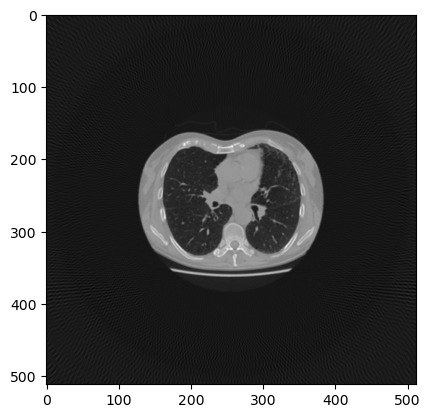

In [ ]:
import matplotlib.pyplot as plt

imgFname = "%s_%dx%dx%d.raw" %(ct.resultsName, ct.recon.imageSize, ct.recon.imageSize, ct.recon.sliceCount)
img = xc.rawread(imgFname, [ct.recon.sliceCount, ct.recon.imageSize, ct.recon.imageSize], 'float')
plt.imshow(img[2,:,:], cmap='gray')
plt.show()